# RUN TOP CELL BEFORE ATTEMPTING TO PLOT - IF PLOTTING CODE IS ALREADY RUNNING, STOP KERNEL BEFORE TRYING TO CHANGE RUN PATH

In [3]:
import glob
import os
import math
from decimal import Decimal
import matplotlib 
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.colors
import matplotlib.cm
import pandas as pd
import numpy as np
import time

#Enter path to run directory where NuGrid data is stored (must contain isotopedatabase.txt and iso_massf files)
path = '/shared/storage/physnp/ahs539/Nugrid/NuPPN/frames/ppn/Full_iniab_CE_runs/15M_32e-5_early_phase/f1a5mcr1.5md32e-5/N_Traj_rmin=1.0422E+06/'
#enter a name for saving figures
run_name = 'test'
save_path = 'path/to/save/directory'
#save figure? 
save_figure = False #False/True

#Limits and parameters
Max_Z = 130
Min_Z = -1
Max_N = 90
Min_N = -1
iso_upper = 1
Isomass_Lim = 1e-15
alpha = 0.8 # level of transparency 
top_iso = []

#read in the list of stable isotopes for plotting
dtype = [('col1', int), ('col2', 'int'), ('col3', 'U1'), ('col4', 'U1'), 
         ('col5', 'U10'), ('col6', float), ('col7', float), ('col8', float), ('col9', int)]
stable_list = pd.read_csv('Stable_isotope.DAT', header=None, skiprows=47, delim_whitespace=True)
stable = stable_list.values.tolist()
only_stable = []
for I in range(len(stable)):
    if stable[I][2] == '-':
        only_stable.append(stable[I][0:4])

/tmp/ipykernel_249679/3766567636.py:32: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  stable_list = pd.read_csv('Stable_isotope.DAT', header=None, skiprows=47, delim_whitespace=True)


In [4]:
ZtoSym = {0:'Nn', 1:'H', 2:'He', 3:'Li', 4:'Be', 5:'B', 6:'C', 7:'N', 8:'O', 9:'F',
10:'Ne', 11:'Na', 12:'Mg', 13:'Al', 14:'Si', 15:'P', 16:'S', 17:'Cl', 18:'Ar',
19:'K', 20:'Ca', 21:'Sc', 22:'Ti', 23:'V', 24:'Cr', 25:'Mn', 26:'Fe', 27:'Co',
28:'Ni', 29:'Cu', 30:'Zn', 31:'Ga', 32:'Ge', 33:'As', 34:'Se', 35:'Br', 36:'Kr',
37:'Rb', 38:'Sr', 39:'Y', 40:'Zr', 41:'Nb', 42:'Mo', 43:'Tc', 44:'Ru', 45:'Rh',
46:'Pd', 47:'Ag', 48:'Cd', 49:'In', 50:'Sn', 51:'Sb', 52:'Te', 53:'I', 54:'Xe',
55:'Cs', 56:'Ba', 57:'La', 58:'Ce', 59:'Pr', 60:'Nd', 61:'Pm', 62:'Sm', 63:'Eu',
64:'Gd', 65:'Tb', 66:'Dy', 67:'Ho', 68:'Er', 69:'Tm', 70:'Yb', 71:'Lu', 72:'Hf',
73:'Ta', 74:'W', 75:'Re', 76:'Os', 77:'Ir', 78:'Pt', 79:'Au', 80:'Hg', 81:'Tl',
82:'Pb', 83:'Bi', 84:'Po', 85:'At', 86:'Rn', 87:'Fr', 88:'Ra', 89:'Ac', 90:'Th',
91:'Pa', 92:'U', 93:'Np', 94:'Pu', 95:'Am', 96:'Cm', 97:'Bk', 98:'Cf', 99:'Es',
100:'Fm', 101:'Md', 102:'No', 103:'Lr', 104:'Rf', 105:'Db', 106:'Sg', 107:'Bh',
108:'Hs', 109:'Mt', 110:'Ds', 111:'Rg', 112:'Cn', 113:'Nh', 114:'Fl', 115:'Mc',
116:'Lv', 117:'Ts', 118:'Og', 119:'Ze', 120:'Zf', 121:'Zg', 122:'Zh', 123:'Zi',
124:'Zj', 125:'Zk', 126:'Zl', 127:'Zm', 128:'Yn', 129:'Zo', 130:'Zp', 131:'Zq',
132:'Yr', 133:'Zs', 134:'Zt', 135:'Zu', 136:'Zv', 137:'Zw', 138:'Zx', 139:'Zy',
140:'Zz'}

SymtoZ = {value: key for key, value in ZtoSym.items()}

def ZtoSymbol(Z):
    if Z in ZtoSym:
        return ZtoSym[Z]
    else:
        return f"No conversion found for {Z}"

def SymboltoZ(element):
    element_lower = re.sub(r'\d', '', element.strip().lower())
    for number, symbol in ZtoSym.items():
        if len(element.strip()) == 1:
            if element.strip() == 'p':
                return '1'
            if element.strip() == 'd':
                return '1'
            if element.strip() == 't':
                return '1'
            if element.strip() == 'nn':
                return '0'
          
    for number, symbol in ZtoSym.items():
        if symbol.lower() == element_lower:
            return number
        elif element_lower == 'al-':
            return '13'
        elif element_lower == 'al*':
            return '13'
    return None

# Single trajectory read and plot

In [9]:
#Final isomass read in
list = sorted(os.listdir(path))#repeated for isomass data
Mass = [x for x in list if x.startswith('iso_massf') and x.endswith('.DAT')]
mass_in = pd.read_csv(path + Mass[-1], sep='\s+',
                          skiprows = 7, header = None,
                          usecols =[x for x in range(0,5)], dtype='string')
#Convert to a list. 
mass_data_1 = mass_in.values.tolist()

#Initial isomass read in
Mass = [x for x in list if x.startswith('iso_massf') and x.endswith('.DAT')]
mass_in = pd.read_csv(path + Mass[0], sep='\s+',
                          skiprows = 7, header = None,
                          usecols =[x for x in range(0,5)], dtype='string')
#Convert to a list. 
mass_data_2 = mass_in.values.tolist()


In [10]:
A =0
np_mass = np.array(mass_data_1, dtype='float')
A = np.max(np_mass[:, 4])  # finds the max flux value
print('Max mass value = ' + str(A))
print('Total mass in system = ' +str(np.sum(np_mass[:, 4])))

Max mass value = 0.981051
Total mass in system = 1.0000003256466028


### Final iso mass chart

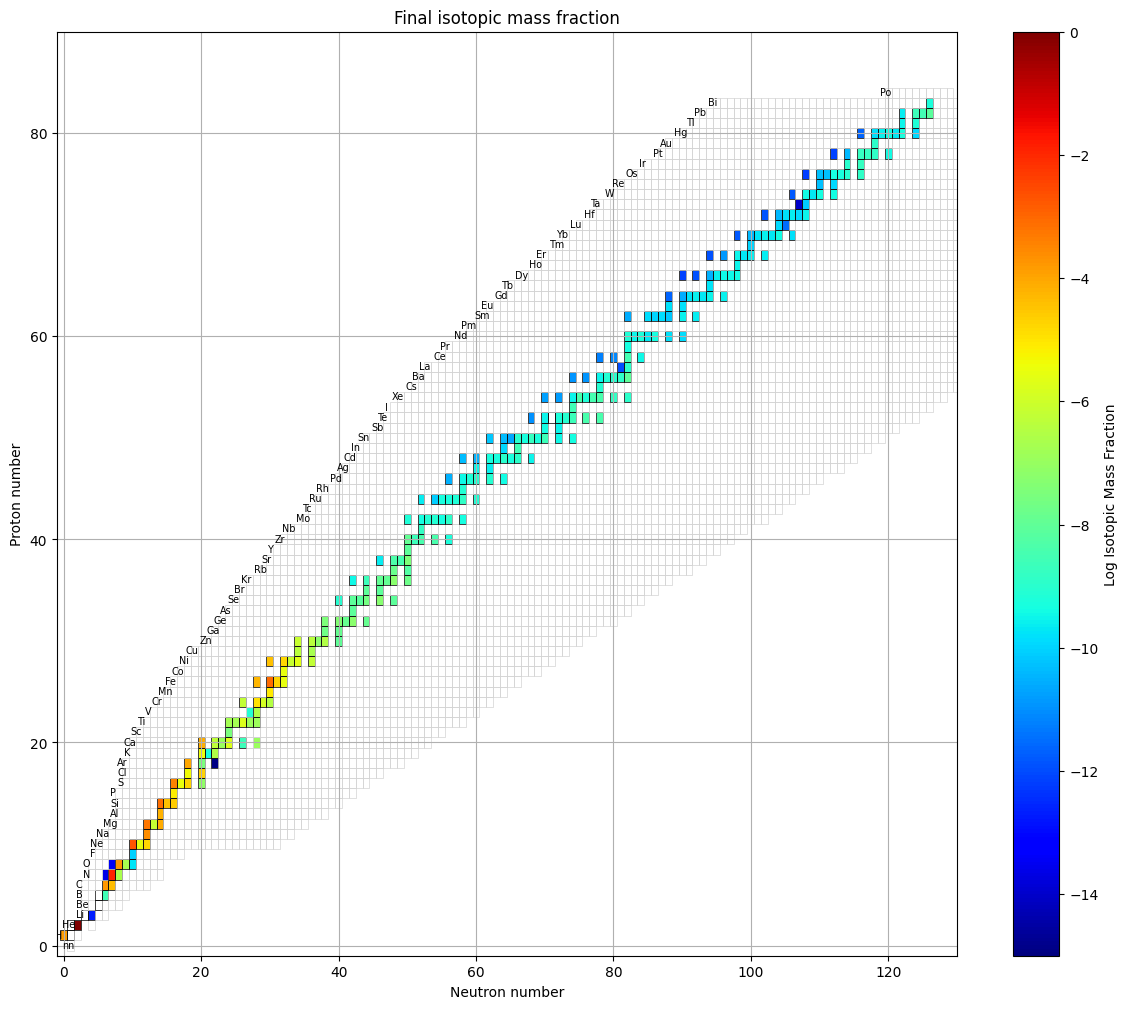

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(18,12))
plt.xlim(-1, 200)#template limits - set these larger than the highest Z and A isotope 
plt.ylim(-1, 85)
#plt.title(str(Mass[timestep]))
#Readin isotopedatabase.txt into pandas array 
iso_db_path = path + 'isotopedatabase.txt'
iso_db_in = pd.read_csv(iso_db_path, sep='\s+', 
                        skiprows=2,dtype='string', #skip to isotope data in file reading
                        usecols=[x for x in range(0,5)]) # use only 6 columns to store data (shape of file)
iso_db_list = iso_db_in.values.tolist()

cmap = cm = plt.get_cmap('jet')#'cubehelix'
norm = matplotlib.colors.Normalize(vmin = math.log(Isomass_Lim, 10), vmax = math.log(iso_upper, 10))
scalarMap = matplotlib.cm.ScalarMappable(norm = norm, cmap = cmap)
scalarMap.set_array([])

for i in range(len(mass_data_1)):
    if float(mass_data_1[i][4]) > Isomass_Lim and float(mass_data_1[i][4]) < iso_upper:
        plt.gca()
        art_1 = mpatches.Rectangle(xy = (float(mass_data_1[i][2])-0.5-float(mass_data_1[i][1]) , float(mass_data_1[i][1])-0.5), width = 1, height = 1, edgecolor='lightgrey', facecolor = cmap(norm(math.log(float(mass_data_1[i][4]), 10))), fill =True, lw =0.5)
        ax.add_patch(art_1)

#add the rextangles
j = 0
for i in range(len(iso_db_list)): # list through each isotope
    iso_db_list[i][0] = float(iso_db_list[i][0])#convert Z to float
    iso_db_list[i][1] = float(iso_db_list[i][1])#convert A to float
    #plt.gca()
    if iso_db_list[i][0] == float(only_stable[j][0]) and iso_db_list[i][1] == float(only_stable[j][1]):
        art_1 = mpatches.Rectangle(xy = (iso_db_list[i][1]-0.5-iso_db_list[i][0] , iso_db_list[i][0]-0.5), width = 1, height = 1, fc='none', ec='k', fill =True, lw =0.5) #draw box around each isotope
        # ax[0].text(iso_db_list[i][1]-iso_db_list[i][0] , iso_db_list[i][0], iso_db_list[i][2] + str(int(iso_db_list[i][1])), ha = 'center', va = 'center', fontsize = 'small', clip_on = True)#add isotope label
        j = j +1
    else:    
        art_1 = mpatches.Rectangle(xy = (iso_db_list[i][1]-0.5-iso_db_list[i][0] , iso_db_list[i][0]-0.5), width = 1, height = 1, fc='none', ec='lightgrey', fill =False, lw =0.5) #draw box around each isotope
    ax.add_patch(art_1)
    plt.gcf()
    if iso_db_list[i][2] != iso_db_list[i-1][2]:
        plt.gcf()
        ax.text(iso_db_list[i][1]-1.25-iso_db_list[i][0], iso_db_list[i][0]-0.25, iso_db_list[i][2], fontsize ='x-small', clip_on = True)#add isotope label

plt.colorbar(scalarMap, ax=ax, label = 'Log Isotopic Mass Fraction', orientation = 'vertical')
#plt.title(str('flux_'+ "{0:0=5d}".format(k+1)))
ax.set_ylabel('Proton number')
ax.set_xlabel('Neutron number')

ax.set_xlim(Min_Z, Max_Z)
ax.set_ylim(Min_N, Max_N)


ax.set_title('Final isotopic mass fraction')

ax.grid(True)
plt.subplots_adjust(hspace=0.3, right = 0.75)
#plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05
if save_figure == True:
    plt.savefig(save_path + '/' + run_name + '_iso_mass_chart.png',  bbox_inches='tight')
else:
    plt.show()

### Final and initial isotopic mass fraction charts

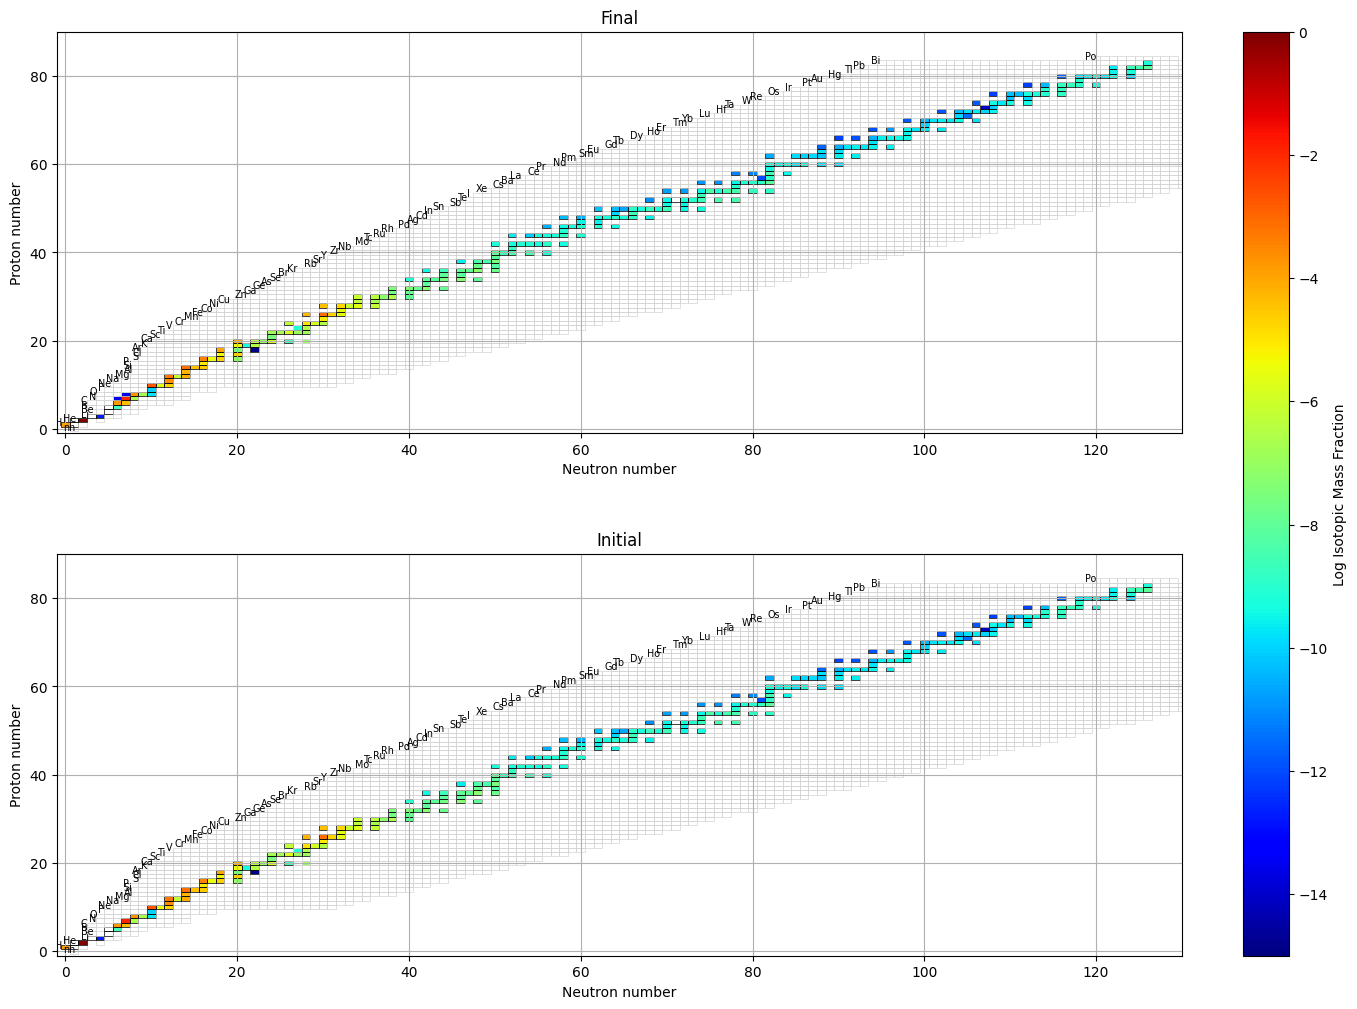

In [12]:
fig, ax = plt.subplots(2, 1, figsize=(18,12))
plt.xlim(-1, 200)#template limits - set these larger than the highest Z and A isotope 
plt.ylim(-1, 85)
#plt.title(str(Mass[timestep]))
#Readin isotopedatabase.txt into pandas array 
iso_db_path = path + 'isotopedatabase.txt'
iso_db_in = pd.read_csv(iso_db_path, sep='\s+', 
                        skiprows=2,dtype='string', #skip to isotope data in file reading
                        usecols=[x for x in range(0,5)]) # use only 6 columns to store data (shape of file)
iso_db_list = iso_db_in.values.tolist()

cmap = cm = plt.get_cmap('jet')#'cubehelix'
norm = matplotlib.colors.Normalize(vmin = math.log(Isomass_Lim, 10), vmax = math.log(iso_upper, 10))
scalarMap = matplotlib.cm.ScalarMappable(norm = norm, cmap = cmap)
scalarMap.set_array([])

for i in range(len(mass_data_1)):
    if float(mass_data_1[i][4]) > Isomass_Lim and float(mass_data_1[i][4]) < iso_upper:
        plt.gca()
        art_1 = mpatches.Rectangle(xy = (float(mass_data_1[i][2])-0.5-float(mass_data_1[i][1]) , float(mass_data_1[i][1])-0.5), width = 1, height = 1, edgecolor='lightgrey', facecolor = cmap(norm(math.log(float(mass_data_1[i][4]), 10))), fill =True, lw =0.5)
        ax[0].add_patch(art_1)
for i in range(len(mass_data_2)):
    if float(mass_data_2[i][4]) > Isomass_Lim and float(mass_data_2[i][4]) < iso_upper:
        plt.gca()
        art_2 = mpatches.Rectangle(xy = (float(mass_data_2[i][2])-0.5-float(mass_data_2[i][1]) , float(mass_data_2[i][1])-0.5), width = 1, height = 1, edgecolor='lightgrey', facecolor = cmap(norm(math.log(float(mass_data_2[i][4]), 10))), fill =True, lw =0.5)
        ax[1].add_patch(art_2)

j = 0
for i in range(len(iso_db_list)): # list through each isotope
    iso_db_list[i][0] = float(iso_db_list[i][0])#convert Z to float
    iso_db_list[i][1] = float(iso_db_list[i][1])#convert A to float
    #plt.gca()
    if iso_db_list[i][0] == float(only_stable[j][0]) and iso_db_list[i][1] == float(only_stable[j][1]):
        art_a = mpatches.Rectangle(xy = (iso_db_list[i][1]-0.5-iso_db_list[i][0] , iso_db_list[i][0]-0.5), width = 1, height = 1, fc='none', ec='k', fill =True, lw =0.5) #draw box around each isotope
        art_1 = mpatches.Rectangle(xy = (iso_db_list[i][1]-0.5-iso_db_list[i][0] , iso_db_list[i][0]-0.5), width = 1, height = 1, fc='none', ec='k', fill =True, lw =0.5) #draw box around each isotope
        # ax[0].text(iso_db_list[i][1]-iso_db_list[i][0] , iso_db_list[i][0], iso_db_list[i][2] + str(int(iso_db_list[i][1])), ha = 'center', va = 'center', fontsize = 'small', clip_on = True)#add isotope label
        # ax[1].text(iso_db_list[i][1]-iso_db_list[i][0] , iso_db_list[i][0], iso_db_list[i][2] + str(int(iso_db_list[i][1])), ha = 'center', va = 'center', fontsize = 'small', clip_on = True)#add isotope label
        j = j +1
    else:    
        art_a = mpatches.Rectangle(xy = (iso_db_list[i][1]-0.5-iso_db_list[i][0] , iso_db_list[i][0]-0.5), width = 1, height = 1, fc='none', ec='lightgrey', fill =False, lw =0.5) #draw box around each isotope
        art_1 = mpatches.Rectangle(xy = (iso_db_list[i][1]-0.5-iso_db_list[i][0] , iso_db_list[i][0]-0.5), width = 1, height = 1, fc='none', ec='lightgrey', fill =False, lw =0.5) #draw box around each isotope
    ax[0].add_patch(art_a)
    ax[1].add_patch(art_1)
    plt.gcf()
    if iso_db_list[i][2] != iso_db_list[i-1][2]:
        plt.gcf()
        ax[0].text(iso_db_list[i][1]-1.25-iso_db_list[i][0], iso_db_list[i][0]-0.25, iso_db_list[i][2], fontsize ='x-small', clip_on = True)#add isotope label
        ax[1].text(iso_db_list[i][1]-1.25-iso_db_list[i][0], iso_db_list[i][0]-0.25, iso_db_list[i][2], fontsize ='x-small', clip_on = True)#add isotope label


plt.colorbar(scalarMap, ax=ax, label = 'Log Isotopic Mass Fraction', orientation = 'vertical')
#plt.title(str('flux_'+ "{0:0=5d}".format(k+1)))
ax[0].set_ylabel('Proton number')
ax[0].set_xlabel('Neutron number')
ax[1].set_ylabel('Proton number')
ax[1].set_xlabel('Neutron number')


ax[0].set_xlim(Min_Z, Max_Z)
ax[0].set_ylim(Min_N, Max_N)
ax[1].set_xlim(Min_Z, Max_Z)
ax[1].set_ylim(Min_N, Max_N)

ax[0].set_title('Final')
ax[1].set_title('Initial')

ax[1].grid(True)
ax[0].grid(True)
plt.subplots_adjust(hspace=0.3, right = 0.75)
#plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05)
if save_figure == True:
    plt.savefig(save_path + '/' + run_name + '_iso_mass_chart.png',  bbox_inches='tight')
else:
    plt.show()